In [1]:
import os

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

import networkx as nx

import copy

import random

from collections import defaultdict



!pip install particle pennylane

!pip install torch_geometric

# import energyflow

from particle import Particle

import pennylane as qml

from tqdm import tqdm



import torch

import torch.nn as nn

from torch_geometric.nn import GCNConv

from torch.nn import Linear, ReLU, Sigmoid, ModuleList, LeakyReLU, Linear, BatchNorm1d

from torch_geometric.nn import GATConv, global_mean_pool, global_max_pool

from torch_geometric.utils import add_self_loops, degree

from torch_geometric.data import Data, Dataset

from torch.utils.data import Dataset

from torch_geometric.utils import to_networkx

from torch.optim import Adam

from torch_geometric.loader import DataLoader

from torch_geometric.utils import subgraph

import torch.nn.functional as F



from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve

from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve



import wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.5/290.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.9 MB/s eta 0:00:00


In [2]:
os.chdir('..');

# print(os.getcwd())



DATA_PATH = "../"

MODEL_PATH = "/kaggle/working/"

BATCH_SIZE = 128

LEARNING_RATE = 1e-3

EPOCHS = 10

MARGIN = 1.0

In [3]:
n_connections = nodes_per_graph = 6

input_dims = 8

hidden_dims = [64,32,32]

output_dims = 8

n_qubits = N_QUBITS = 6

q_depth = n_layers = N_LAYERS = 1

epochs = 50

lr = 1e-3

train_ratio = 0.8

val_ratio = 0.1

test_ratio = 0.1

batch_size = 1000

In [4]:
import numpy as np

import torch

from particle import Particle

from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader

import os

import matplotlib.pyplot as plt

from collections import defaultdict

# from .data_preprocessing_augmentation import graph_augment



class DataLoader:

    '''Loads the training and test pairs'''

    def __init__(self, file_path):

        data = np.load(file_path, allow_pickle=True)

        self.pairs_train = np.expand_dims(data["pairs_train"], -1)

        self.labels_train = data["labels_train"]

        self.pairs_test = np.expand_dims(data["pairs_test"], -1)

        self.labels_test = data["labels_test"]

    

    def get_train_data(self):

        return self.pairs_train, self.labels_train

    

    def get_test_data(self):

        return self.pairs_test, self.labels_test



class LabeledContrastiveDatasetQG():

    """

    Dataset class to load images from .npz files, convert them to PyTorch tensors, and return x1 and x2.

    """



    def __init__(self, file, transforms=None):

        #self.files = [os.path.join(folder, file) for file in os.listdir(folder) if file.endswith('.npz')]

        self.file=file

        self.transform = transforms

        

    def __len__(self):

        return len(self.file)

    

    def __getitem__(self, idx):

        """

        Load the npz file, convert x1 and x2 to PyTorch tensors, and return them.

        """

        # file_path = self.files[idx]

        # data = np.load(file_path)

        

        data = np.load(self.file, allow_pickle=True)

        pairs = data["pairs"]

        labels = data["labels"]

        

        pairs = pairs[:,:,:,:,3]

        pairs = pairs.reshape(-1, 2, 125, 125, 1)

        x1 = pairs[:,0]

        x2 = pairs[:,1,]



        def crop_center(img,cropx,cropy):

            x,y = img.shape[1:3]

            startx = x//2-(cropx//2)

            starty = y//2-(cropy//2)    

            return img[:,startx:startx+cropx,starty:starty+cropy,:]

        

        x1 = crop_center(x1,40,40)

        x2 = crop_center(x2,40,40)



        # Reshape the input tensors to add the channel dimension

        # x1 = x1.reshape(-1, 2, 125, 125, 1)

        # x2 = x2.reshape(-1, 2, 125, 125, 1)

        

        # Apply transforms if any

        if self.transform is not None:

            x1 = self.transform(x1)

            x2 = self.transform(x2)



        # Convert numpy arrays to PyTorch tensors

        x1_tensor = torch.tensor(x1, dtype=torch.float32).permute(0, 3, 1, 2)

        x2_tensor = torch.tensor(x2, dtype=torch.float32).permute(0, 3, 1, 2)

        labels = torch.Tensor(labels)



        return {"x1": x1_tensor, "x2": x2_tensor, 'labels':labels}

    

def preprocess_fixed_nodes(x_data,y_data,nodes_per_graph=10): 

    '''Preprocesses graph dataset (courtesy to Roy's open-source code)'''

    print('--- Finding All Unique Particles ---')

    unique_particles = np.unique(x_data[:,:,3])

    x_data = torch.tensor(x_data)

    y_data = torch.tensor(y_data)

    print()

    print('--- Inserting Masses ---')

    masses = torch.zeros((x_data.shape[0],x_data.shape[1]))

    for i,particle in tqdm(enumerate(unique_particles)):

        if particle!=0:

            mass = Particle.from_pdgid(particle).mass/1000

            inds = torch.where(particle==x_data[:,:,3])

            masses[inds]=mass # GeV

    print()

    print('--- Calculating Momenta and Energies ---')

    pt        = x_data[:,:,0]     # transverse momentum

    rapidity  = x_data[:,:,1]     # rapidity

    phi       = x_data[:,:,2]     # azimuthal angle

    

    mt        = (pt**2+masses**2).sqrt() # Transverse mass

    energy    = mt*torch.cosh(rapidity) # Energy per multiplicity bin

    e_per_jet = energy.sum(axis=1)  # total energy per jet summed across multiplicity bins



    px = pt*torch.cos(phi)  # momentum in x

    py = pt*torch.sin(phi)  # momentum in y

    pz = mt*torch.sinh(rapidity)  # momentum in z

    

    # three momentum

    p  = torch.cat(( px[:,:,None],  

                     py[:,:,None],

                     pz[:,:,None]), dim=2 )



    p_per_jet        = (p).sum(axis=1)  # total componet momentum per jet

    pt_per_Mbin      = (p_per_jet[:,:2]**2).sum(axis=1).sqrt()  # transverse momentum per jet

    mass_per_jet     = (e_per_jet**2-(p_per_jet**2).sum(axis=1)).sqrt() # mass per jet

    rapidity_per_jet = torch.log( (e_per_jet+p_per_jet[:,2])/(e_per_jet-p_per_jet[:,2]) )/2  # rapidity per jet from analytical formula

    end_multiplicity_indx_per_jet = (pt!=0).sum(axis=1).int() # see where the jet (graph) ends

    

    x_data = torch.cat( ( x_data[:,:,:3],

                          x_data[:,:,4:],

                          masses[:,:,None],

                          energy[:,:,None],

                          p), dim=2)

    

    x_data_max = (x_data.max(dim=1).values).max(dim=0).values

    x_data = x_data/x_data_max



    print()

    print('--- Calculating Edge Tensors ---')

    N = x_data[:,0,3].shape[0]  # number of jets (graphs)

    M = nodes_per_graph #x_data[0,:,3].shape[0]  # number of max multiplicty

    connections = nodes_per_graph

    edge_tensor = torch.zeros((N,M,M))

    edge_indx_tensor = torch.zeros((N,2,connections*(connections-1) )) # M*(connections-1) is the max number of edges we allow per jet

    edge_attr_matrix = torch.zeros((N,connections*(connections-1),1)) 

    

    for jet in tqdm(range(N)):

        stop_indx = end_multiplicity_indx_per_jet[jet] #connections # stop finding edges once we hit zeros -> when we hit 10

        if end_multiplicity_indx_per_jet[jet]>=connections:

            for m in range(connections):

                edge_tensor[jet,m,:] = torch.sqrt( (phi[jet,m]-phi[jet,:connections])**2 + (rapidity[jet,m]-rapidity[jet,:connections])**2 )

            edges_exist_at = torch.where(edge_tensor[jet,:,:].abs()>0)

            edge_indx_tensor[jet,:,:(edge_tensor[jet,:,:].abs()>0).sum()] = torch.cat((edges_exist_at[0][None,:],edges_exist_at[1][None,:]),dim=0).reshape((2,edges_exist_at[0].shape[0]))   

            edge_attr_matrix[jet,:(edge_tensor[jet,:,:].abs()>0).sum(),0]  =  edge_tensor[jet,edges_exist_at[0],edges_exist_at[1]].flatten()



    end_edges_indx_per_jet = (edge_attr_matrix!=0).sum(axis=1).int()

    keep_inds =  torch.where(end_edges_indx_per_jet>=connections)[0]

    

    edge_tensor = edge_tensor/edge_tensor.max()

    edge_attr_matrix = edge_attr_matrix/edge_attr_matrix.max()

    

    graph_help = torch.cat( ( (energy.max(axis=1).values/e_per_jet).reshape(x_data[:,0,3].shape[0],1),

                              (mass_per_jet).reshape(x_data[:,0,3].shape[0],1),

                              (end_multiplicity_indx_per_jet).reshape(x_data[:,0,3].shape[0],1).int(),

                              (end_edges_indx_per_jet).reshape(x_data[:,0,3].shape[0],1).int() ), dim=1)

        

    return x_data[keep_inds,:nodes_per_graph], y_data[keep_inds].long(), edge_tensor[keep_inds], edge_indx_tensor[keep_inds].long(), edge_attr_matrix[keep_inds], graph_help[keep_inds]





def create_contrastive_graph_pairs(dataset):

    pairs = []

    labels = []

    # Group graphs by their labels (0 or 1)

    label_to_graphs = defaultdict(list)

    for data in dataset:

        label_to_graphs[data.y.item()].append(data)



    # Create pairs for positive class

    for data in label_to_graphs[1]:  # For each positive graph

        data_aug = graph_augment(data)  # Create an augmented version

        pairs.append((data, data_aug))  # Add the original and augmented graph as a pair

        labels.append(1)  # Label 1 for positive pair (similar)



    # Create pairs for negative class

    for data in label_to_graphs[0]:  # For each negative graph

        data_aug = graph_augment(data)  # Create an augmented version

        pairs.append((data, data_aug))  # Add the original and augmented graph as a pair

        labels.append(0)  # Label 0 for negative pair (dissimilar)



    return pairs, labels



# Required Imports

import numpy as np



# Preprocess the dataset

def preprocess_data(images, labels):

    # Add a dimenison for channel

    images = np.expand_dims(images, -1)

    # Normalize

    images = images.astype('float32') / 255.0  

    return images, labels





def crop(images, size):

    x = np.argmax(np.mean(images[:, :, :, 0], axis=0))

    center = [int(x/size), x%size]

    img_size = 8

    images = images[:, (center[0]-int(img_size/2)):(center[0]+int(img_size/2)), (center[1]-int(img_size/2)):(center[1]+int(img_size/2))]

    return images



# x_train = x_train[:,:,:,0]

# x_test = x_test[:,:,:,0]

# x_train, y_train = preprocess_data(x_train, y_train)

# x_test, y_test = preprocess_data(x_test, y_test)

# x_train = crop(x_train, 32)

# x_test = crop(x_test, 32)



# print(f"After Data Preprocessing: x_train shape {x_train.shape}, x_test shape: {x_test.shape}")

# print(f"After Data Preprocessing: y_train shape {y_train.shape}, y_test shape: {y_test.shape}")



# Create pairs of images and labels

def create_pairs(images, labels):

    pairs = []

    pair_labels = []



    num_classes = len(np.unique(labels)) # 2

    digit_indices = [np.where(labels == i)[0] for i in range(num_classes)]

    # print(digit_indices)



    for idx1 in range(len(images)):

        x1, label1 = images[idx1], labels[idx1]

        idx2 = np.random.choice(digit_indices[int(label1)])

        x2 = images[idx2]



        # if x1==x2, label set to 1

        pairs.append([x1, x2])

        pair_labels.append(1)



        # if x1!=x2, label set to 0

        label2 = (label1 + np.random.randint(1, num_classes)) % num_classes

        idx2 = np.random.choice(digit_indices[int(label2)])

        x2 = images[idx2]

        pairs.append([x1, x2])

        pair_labels.append(0)



    return np.array(pairs), np.array(pair_labels)



# pairs_train, labels_train = create_pairs(x_train, y_train)

# pairs_test, labels_test = create_pairs(x_test, y_test)



# print(f"After pair creation: pairs_train: {pairs_train.shape}, pairs_test: {pairs_test.shape}")

# print(f"After pair creation: labels_train: {labels_train.shape}, labels_test: {labels_test.shape}")



# np.savez_compressed('../../data/electron-photon-pairs.npz', **{

#     'pairs_train': pairs_train,

#     'labels_train':labels_train,

#     'pairs_test':pairs_test,

#     'labels_test':labels_test

# })





import cv2

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import torch

from torch_geometric.utils import subgraph







def add_fourth_channel(images):

    '''4th channel from overlay of the 3 channels'''

    images_with_four_channels = []

    for image in images:

        superimposed_channel = np.mean(image, axis=2, keepdims=True)

        image_with_four_channels = np.concatenate((image, superimposed_channel), axis=2)

        images_with_four_channels.append(image_with_four_channels)

    return np.array(images_with_four_channels)



# Soft Transformations

def rotate_image(image, angle):

    (h, w) = image.shape[:2]

    center = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    rotated = cv2.warpAffine(image, M, (w, h))

    return rotated



def translate_image(image, x, y):

    M = np.float32([[1, 0, x], [0, 1, y]])

    shifted = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

    return shifted



def scale_image(image, scale_factor):

    h, w = image.shape[:2]

    resized = cv2.resize(image, (int(w * scale_factor), int(h * scale_factor)))

    return resized



def shear_image(image, shear_factor):

    M = np.float32([[1, shear_factor, 0], [0, 1, 0]])

    sheared = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

    return sheared



def adjust_brightness(image, brightness_factor):

    hsv = cv2.cvtColor(image[:, :, :3], cv2.COLOR_BGR2HSV)

    h, s, v = cv2.split(hsv)

    v = cv2.add(v, brightness_factor)

    v[v > 255] = 255

    v[v < 0] = 0

    final_hsv = cv2.merge((h, s, v))

    image_bright = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

    image[:, :, :3] = image_bright

    return image



def add_noise(image, noise_factor):

    row, col, ch = image.shape

    mean = 0

    sigma = noise_factor ** 0.5

    gauss = np.random.normal(mean, sigma, (row, col, ch))

    gauss = gauss.reshape(row, col, ch)

    noisy = image + gauss

    return noisy





# collinear transformations

def affine_transform(image, pts1, pts2):

    M = cv2.getAffineTransform(pts1, pts2)

    rows, cols, ch = image.shape

    affine_transformed = cv2.warpAffine(image, M, (cols, rows))

    return affine_transformed



def perspective_transform(image, pts1, pts2):

    M = cv2.getPerspectiveTransform(pts1, pts2)

    rows, cols, ch = image.shape

    perspective_transformed = cv2.warpPerspective(image, M, (cols, rows))

    return perspective_transformed





# Normalisation

def z_score():

    if len(image.shape) == 3 and image.shape[2] == 3:

        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    mean = np.mean(image)

    std = np.std(image)

    z_score_transformed = (image - mean) / std

    normalized_transformed = cv2.normalize(z_score_transformed, None, 0, 255, cv2.NORM_MINMAX)

    normalized_transformed = normalized_transformed.astype(np.uint8)

    return normalized_transformed





# Heatmaps

def compute_relative_difference(images):

    avgs = np.mean(images, axis=0)

    relative_diffs = np.zeros_like(avgs)

    for img in images:

        relative_diffs += np.abs(img - avgs) / (avgs + 1e-10)  # Adding a small constant to avoid division by zero

    relative_diffs /= len(images)

    return relative_diffs



def plot_heatmaps(relative_diffs):

    h, w, c = relative_diffs.shape

    for i in range(c):

        plt.figure(figsize=(10, 8))

        sns.heatmap(relative_diffs[:, :, i], cmap="viridis")

        plt.title(f'Channel {i+1} Sensitivity Heatmap')

        plt.show()





# Log transformation of the 4th channel

def preprocess_4th_channel(image):    

    if image.shape[-1] < 3:

        raise ValueError("Image must have at least 4 channels.")

    fourth_channel = image[:, :, 3]

    transformed_channel = np.log(np.abs(fourth_channel) + 1e-6)

    normalized_channel = (transformed_channel - transformed_channel.min()) / (transformed_channel.max() - transformed_channel.min() + 1e-6)

    return normalized_channel





def preprocess_all_images(images):

    if images.shape[-1] < 4:

        raise ValueError("Each image must have at least 4 channels.")



    # Extract the 4th channels from all images

    fourth_channels = images[:, :, :, 3]



    # Apply logarithmic transformation and normalization to the 4th channels

    transformed_channels = np.log(np.abs(fourth_channels) + 1e-6)

    min_vals = transformed_channels.min(axis=(1, 2), keepdims=True)

    max_vals = transformed_channels.max(axis=(1, 2), keepdims=True)

    normalized_channels = (transformed_channels - min_vals) / (max_vals - min_vals + 1e-6)



    return normalized_channels





# graph augmentations

# Function to randomly drop nodes in a graph

def drop_nodes(data, drop_prob=0.2):

    node_mask = torch.rand(data.x.size(0)) > drop_prob

    data.x = data.x[node_mask]

    data.edge_index, _ = subgraph(node_mask, data.edge_index, relabel_nodes=True)

    return data



# Function to randomly drop edges in a graph

def drop_edges(data, drop_prob=0.2):

    edge_mask = torch.rand(data.edge_index.size(1)) > drop_prob

    data.edge_index = data.edge_index[:, edge_mask]

    return data



# Function to randomly mask node features in a graph

def mask_features(data, mask_prob=0.2):

    feature_mask = torch.rand(data.x.size()) > mask_prob

    data.x = data.x * feature_mask.float()

    return data



# Define the augmentation function

def graph_augment(data):

    data_aug = data.clone()

    data_aug = drop_nodes(data_aug, drop_prob=0.2)

    data_aug = drop_edges(data_aug, drop_prob=0.1)

    data_aug = mask_features(data_aug, mask_prob=0.2)

    return data_aug



import cv2

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns



def plot(channel=0):

    '''Plots specified channel of quark-gluon dataset'''

    fig2 = plt.figure(figsize=(10,10))

    r = 1

    c = 2

    index = [np.where(data['y_train'] == 0)[0], np.where(data['y_train'] == 1)[0]]

    for i in range(2):

        fig2.add_subplot(r,c,i+1)

        plt.imshow(np.log(np.mean(data['x_train'][index[i],:,:,channel], axis=0)))

        plt.title('Quark' if i == 0 else 'Gluon')

        

def plot_image_grid_superimposed(data, label, channel=0, rows=5, cols=5):

    '''Plots image grid of the 4th channel'''

    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

    for i in range(rows):

        for j in range(cols):

            # axes[i, j].imshow(data[i * cols + j, :, :, channel])

            axes[i, j].imshow(data[i * cols + j, :, :, 3])

            axes[i, j].axis('off')

    plt.suptitle(f'{label}')

    plt.show()



def plot_image_grid(data, label, channel=0, rows=5, cols=5):

    '''Plots image grid of specified channel'''

    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

    for i in range(rows):

        for j in range(cols):

            axes[i, j].imshow(data[i * cols + j, :, :, channel])

            axes[i, j].axis('off')

    plt.suptitle(f'{label}')

    plt.show()



def plot_sample_pairs(pairs, labels, shape, num_samples=5):

    '''Plots sample pairs'''

    plt.figure(figsize=(15, num_samples * 2))

    for i in range(num_samples):

        ax = plt.subplot(num_samples, 2, 2 * i + 1)

        plt.imshow(pairs[i, 0].reshape(shape, shape))

        ax.axis('off')



        ax = plt.subplot(num_samples, 2, 2 * i + 2)

        plt.imshow(pairs[i, 1].reshape(shape, shape))

        ax.axis('off')



        label = labels[i]

        plt.title(f'Sample: {i}, Label: {label}')



    plt.tight_layout()

    plt.show()

    

from sklearn.metrics import roc_curve, auc, confusion_matrix

import tensorflow as tf

from sklearn.metrics import confusion_matrix as cmatrix

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import itertools

import wandb

import torch



def run_model_lct(model, epoch, dataloader, lossFn, optimizer=None, train=True, return_embeddings=False):

    if train:

        model.train()

    else:

        model.eval()



    total_loss = 0

    correct = 0

    num_samples = 0

    all_embeddings = []

    all_labels = []



    for batch in dataloader:

        optimizer.zero_grad() if train else None



        # Extract the pairs and labels from the dataloader batch

        data1, data2, labels = batch[0], batch[1], batch[2]

        

        # Get the embeddings for both graphs

        emb1 = model(data1.x.float(), data1.edge_index, data1.batch)

        emb2 = model(data2.x.float(), data2.edge_index, data2.batch)

        

        if return_embeddings:

            # Save embeddings and labels for later use in classification

            all_embeddings.append(emb1.detach().cpu())

            all_labels.append(labels.detach().cpu())



        # Compute contrastive loss

        loss = lossFn(emb1, emb2, labels)

        

        if train:

            loss.backward()

            optimizer.step()



        total_loss += loss.item() * data1.num_graphs

        num_samples += data1.num_graphs



        # Compute accuracy

        with torch.no_grad():

            cos_sim = torch.nn.functional.cosine_similarity(emb1, emb2)

            predictions = (cos_sim > 0.5).long()  # You can adjust the threshold

            correct += (predictions == labels).sum().item()



    avg_loss = total_loss / num_samples

    accuracy = correct / num_samples



    if return_embeddings:

        return torch.cat(all_embeddings, dim=0), torch.cat(all_labels, dim=0)

    return avg_loss, accuracy





def evaluate_precision_recall_accuracy(y_true, y_pred, threshold=0.5):

    '''Returns Precision, Recall and Accuracy'''

    y_pred_binary = (y_pred >= threshold).astype(int)

    

    true_positives = np.sum((y_true == 1) & (y_pred_binary == 1))

    false_positives = np.sum((y_true == 0) & (y_pred_binary == 1))

    false_negatives = np.sum((y_true == 1) & (y_pred_binary == 0))

    true_negatives = np.sum((y_true == 0) & (y_pred_binary == 0))

    

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0

    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

    accuracy = (true_positives + true_negatives) / len(y_true)

    

    return precision, recall, accuracy





def confusion_matrix(y_true, y_pred, threshold=0.5):

    '''Creates confusion matrix'''

    y_pred_binary = (y_pred >= threshold).astype(int)

    

    true_positives = np.sum((y_true == 1) & (y_pred_binary == 1))

    false_positives = np.sum((y_true == 0) & (y_pred_binary == 1))

    false_negatives = np.sum((y_true == 1) & (y_pred_binary == 0))

    true_negatives = np.sum((y_true == 0) & (y_pred_binary == 0))

    

    return np.array([[true_negatives, false_positives],

                     [false_negatives, true_positives]])





def make_cm(y_true,y_pred,classes=None,figsize=(10,10),text_size=15):

    '''Creates a pretty confusion matrix'''

    cm = cmatrix(y_true,tf.round(y_pred))

    cm_norm = cm.astype("float")/cm.sum(axis=1)[:,np.newaxis] # normalise confusion matrix

    n_class = cm.shape[0]



    fig, ax = plt.subplots(figsize=figsize)

    cax = ax.matshow(cm,cmap=plt.cm.Blues)

    fig.colorbar(cax)



    if classes:

      labels=classes

    else:

      labels=np.arange(cm.shape[0])



    ax.set(title="Confusion Matrix", 

          xlabel="Predicted label",

          ylabel="True label",

          xticks=np.arange(n_class),

          yticks=np.arange(n_class),

          xticklabels=labels,

          yticklabels=labels)



    ax.xaxis.set_label_position("bottom")

    ax.xaxis.tick_bottom()



    ax.yaxis.label.set_size(text_size)

    ax.xaxis.label.set_size(text_size)

    ax.title.set_size(text_size)

    

    threshold = (cm.max()+cm.min())/2



    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

      plt.text(j,i,f"{cm[i,j]} ({cm_norm[i,j]*100:.1f})%",

              horizontalalignment="center",

              color="white" if cm[i,j]>threshold else "black",

              size=text_size)





def plot_auc(y_true, y_pred):

    '''Plots AUC-ROC curve'''

    fpr, tpr, _ = roc_curve(y_true, y_pred)

    roc_auc = auc(fpr, tpr)

    

    plt.figure()

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlim([0.0, 1.0])

    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')

    plt.ylabel('True Positive Rate')

    plt.title('Receiver Operating Characteristic')

    plt.legend(loc='lower right')

    plt.show()





# wandb enabled

def plot_auc(labels, preds):

    auc = roc_auc_score(labels, preds)

    fpr, tpr, _ = roc_curve(labels, preds)

    plt.plot(fpr, tpr, label="AUC = {0}".format(auc))

    plt.xlabel('False Positive Rate')

    plt.ylabel('True Positive Rate')

    plt.legend()

#     wandb.log({"Confusion Matrix": wandb.Image(plt)})

    plt.show()



def make_cm(y_true,y_pred,classes=None,figsize=(10,10),text_size=15):

    cm = cmatrix(y_true,y_pred)

    cm_norm = cm.astype("float")/cm.sum(axis=1)[:,np.newaxis] # normalise confusion matrix

    n_class = cm.shape[0]



    fig, ax = plt.subplots(figsize=figsize)

    cax = ax.matshow(cm,cmap=plt.cm.Blues)

    fig.colorbar(cax)



    if classes:

        labels=classes

    else:

        labels=np.arange(cm.shape[0])



    ax.set(title="Confusion Matrix", 

        xlabel="Predicted label",

        ylabel="True label",

        xticks=np.arange(n_class),

        yticks=np.arange(n_class),

        xticklabels=labels,

        yticklabels=labels)



    ax.xaxis.set_label_position("bottom")

    ax.xaxis.tick_bottom()



    ax.yaxis.label.set_size(text_size)

    ax.xaxis.label.set_size(text_size)

    ax.title.set_size(text_size)





    threshold = (cm.max()+cm.min())/2



    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j,i,f"{cm[i,j]} ({cm_norm[i,j]*100:.1f})%",

            horizontalalignment="center",

            color="white" if cm[i,j]>threshold else "black",

            size=text_size)

#     wandb.log({"Confusion Matrix": wandb.Image(fig)})



import torch

import numpy as np

import torch.nn.functional as F

import tensorflow as tf

# from qssl.config import Config

import pennylane as qml

import tensorflow as tf

from tensorflow import keras



def form_pairs(inA, inB):

    

    '''

    Form pairs from two tensors of embeddings. It is assumed that the embeddings at corresponding batch positions are similar

    and all other batch positions are dissimilar 

    '''

    

    b, emb_size = inA.shape

    perms = b**2

    

    labels = [0]*perms; sim_idxs = [(0 + i*b) + i for i in range(b)]

    for idx in sim_idxs:

        labels[idx] = 1

    labels = torch.Tensor(labels)

    

    return(inA.repeat(b, 1), torch.cat([inB[i,:].repeat(b,1) for i in range(b)]), labels.type(torch.LongTensor).to(inA.device))





class NTXent(torch.nn.Module):

    

    '''

    Modified from: https://zablo.net/blog/post/understanding-implementing-simclr-guide-eli5-pytorch/

    '''

    

    def __init__(self, 

                 batch_size, 

                 temperature=0.5,

                 device='cuda'):

        super().__init__()

        self.batch_size = batch_size

        self.register_buffer("temperature", torch.tensor(temperature).to(device))

        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool).to(device)).float())

        self.device = device

            

    def forward(self, emb_i, emb_j):

        """

        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs

        z_i, z_j as per SimCLR paper

        """

        z_i = F.normalize(emb_i, dim=1)

        z_j = F.normalize(emb_j, dim=1)



        representations = torch.cat([z_i, z_j], dim=0)

        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

        

        sim_ij = torch.diag(similarity_matrix, self.batch_size)

        sim_ji = torch.diag(similarity_matrix, -self.batch_size)

        positives = torch.cat([sim_ij, sim_ji], dim=0)

        

        nominator = torch.exp(positives / self.temperature)

        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)

    

        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))

        loss = torch.sum(loss_partial) / (2 * self.batch_size)

        return loss





class ContrastiveLoss(torch.nn.Module):

    """

    Contrastive loss function.

    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf

    """



    

    def __init__(self,

                 distance = lambda x,y: torch.pow(x-y, 2).sum(1),

                 margin=1.0,

                 mode='pairs',

                 batch_size=None,

                 temperature=0.5):

        

        super(ContrastiveLoss, self).__init__()

        self.margin = margin

        self.distance = distance

        self.mode = mode

        

        if self.mode == 'ntxent':

            assert batch_size is not None, "Must specify batch size to use Ntxent Loss"

            self.ntxent = NTXent(batch_size = batch_size, temperature = temperature)

        

    

    

    

    def forward(self, x, y):

        

        if self.mode == 'pairs':

            return(self.forward_pairs(x, y))

        

        elif self.mode == 'ntxent':

            return(self.forward_ntxent(x, y))

    

    

    def forward_ntxent(self, x, y):

        return(self.ntxent(x, y))

    

    def forward_pairs(self, x, y, label=None):

        '''

        Return the contrastive loss between two similar or dissimilar outputs

        '''

        

        assert x.shape==y.shape, str(x.shape) + "does not match input 2: " + str(y.shape)

        

        x, y, label = form_pairs(x,y)

        

        distance = self.distance(x,y)

        

        # When the label is 1 (similar) - the loss is the distance between the embeddings

        # When the label is 0 (dissimilar) - the loss is the distance between the embeddings and a margin

        loss_contrastive = torch.mean((label) * distance +

                                      (1-label) * torch.clamp(self.margin - distance, min=0.0))





        return loss_contrastive





class Losses:

    @staticmethod

    def quantum_fidelity_loss(y_true, y_pred):

        return tf.reduce_mean(tf.square(y_true - y_pred))



    @staticmethod

    def contrastive_pair_loss(margin=MARGIN):

        def loss(y_true, dist):

            y_true = tf.cast(y_true, tf.float32)

            square_dist = tf.square(dist)

            margin_square = tf.square(tf.maximum(margin - dist, 0))

            return tf.reduce_mean(y_true * square_dist + (1 - y_true) * margin_square)

        return loss





class InfoNCELoss(keras.losses.Loss):

    def __init__(self, n_qubits, n_ancillas, q_depth, q_params, temperature=0.1, epsilon=1e-4, negative_mode='unpaired'):

        super(InfoNCELoss, self).__init__()

        self.temperature = temperature

        self.epsilon = epsilon

        self.negative_mode = negative_mode

        self.q_params = q_params

        self.q_depth = q_depth

        self.n_qubits = n_qubits

        self.n_ancillas = n_ancillas



    def call(self, query, positive_key, negative_keys):

        q_in_query = tf.tanh(query) * np.pi / 2.0

        q_in_pos = tf.tanh(positive_key) * np.pi / 2.0



        positive_logit = self.compute_similarity(q_in_query, q_in_pos)



        if self.negative_mode == 'unpaired':

            q_in_neg = tf.tanh(negative_keys) * np.pi / 2.0

            negative_logits = self.compute_similarity(q_in_query, q_in_neg)

        else:

            q_in_neg = tf.tanh(negative_keys) * np.pi / 2.0

            negative_logits = self.compute_similarity(q_in_query, q_in_neg, mode='paired')



        logits = tf.concat([positive_logit, negative_logits], axis=1)

        labels = tf.zeros(len(logits), dtype=tf.int64)

        return tf.keras.losses.sparse_categorical_crossentropy(labels, logits / self.temperature, from_logits=True)



    def compute_similarity(self, query, key, mode='paired'):

        if mode == 'paired':

            similarity = []

            for h1, h2 in zip(query, key):

                q_pair = tf.concat([h1, h2], axis=0)

                sim = quantum_circuit(q_pair, self.q_params, self.q_depth, self.n_qubits, self.n_ancillas, training=True)

                similarity.append(tf.reduce_sum(sim)**2)

            return tf.stack(similarity, axis=0)[:, tf.newaxis]

        else:

            similarity = []

            for h_query in query:

                row_aux = []

                for h_key in key:

                    q_pair = tf.concat([h_query, h_key], axis=0)

                    sim = quantum_circuit(q_pair, self.q_params, self.q_depth, self.n_qubits, self.n_ancillas, training=True)

                    row_aux.append(tf.reduce_sum(sim)**2)

                similarity.append(tf.stack(row_aux, axis=0))

            return tf.stack(similarity, axis=0)

        

def filter_labels(images, labels, label):

    filter_mask = np.isin(labels, [label])

    return images[filter_mask]



import torch

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from sklearn.metrics import roc_auc_score, roc_curve

import wandb

import matplotlib.pyplot as plt

import networkx as nx

from torch_geometric.utils import to_networkx

from sklearn.manifold import TSNE

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc







def extract_embeddings(test_dataloader, model, N, reduce_to_dimension=2, device='cuda'):

    

    '''

    Use a test dataloader and torch model to extract N embeddings, reduce them to 

    reduce_to_dimension dimensions, then organize them into a dataframe with the GT labels

    '''

        

    model.eval()

    m = model

    # m = model.to(device)

    

    embs = None

    labs = None

    tot_cnt = 0

    

    for idx, dat in enumerate(test_dataloader):

        

        # Extract relevent data points from batch

        x1 = dat['x1'] 

        x2 = dat['x2'] 

        labels = dat['labels'].type(torch.LongTensor) 

        

        # Pass inputs through model

        emb1 = m(x1); emb2 = m(x2)

        

        # Add to running lists

        if embs is None:

            embs = torch.cat([emb1, emb2])

        else:

            embs = torch.cat([embs, emb1, emb2])

        

        # Add coloring to list

        if labs is None:

            labs = torch.cat([labels, labels])

        else:

            labs = torch.cat([labs, labels, labels])



        # Check count of points so far

        curr_cnt = x1.shape[0] + x2.shape[0]

        if tot_cnt + curr_cnt >= N:

            break

        tot_cnt += curr_cnt

    

    # If there's only two dimensions in the embeddings we can directly use them

    embs = [np.array(e.cpu().detach()) for e in embs]

    emb_size = embs[0].shape[0]

    

    assert reduce_to_dimension is not None and reduce_to_dimension <= emb_size, "reduce_to_dimension must be integer <= emb dimension"

    if emb_size > reduce_to_dimension:

        from sklearn.decomposition import PCA

        embs = np.array(embs)

        print("performing PCA to reduce embeddings to " + str(reduce_to_dimension) + " dimensions")

        pca = PCA(n_components = reduce_to_dimension)

        embs = pca.fit_transform(embs)

        print(str(pca.explained_variance_ratio_.sum()) + " % variance explained using PCA")



    labs = [x.item() for x in labs]

    df = pd.DataFrame({"Emb": list(embs), "Label": labs})    

    return(df)





def plot_embeddings(emb_df):

    '''

    Plot the DataFrame from extract_embeddings() in 2 dimensions 

    and color by label

    '''

    embs = list(emb_df['Emb'])

    assert embs[0].shape[0] == 2, "Embeddings must be reduced to dimension 2, use reduce_to_dimension param in extract_embeddings"

    

    embs_x = [e[0] for e in embs]; embs_y = [e[1] for e in embs]

    labs = list(emb_df['Label'])

    

    import seaborn as sns

    sns.set_style("darkgrid")

    sns.relplot(x=embs_x, y=embs_y, hue=labs, palette="deep", alpha=0.7, s=75)

    plt.title("Test Embeddings")

#     wandb.log({"Test Embeddings": wandb.Image(plt)})





def plot_auc(labels, preds):

    '''Plotas auc and logs to wandb'''

    auc = roc_auc_score(labels, preds)

    fpr, tpr, _ = roc_curve(labels, preds)

    plt.plot(fpr, tpr, label="AUC = {0}".format(auc))

    plt.xlabel('False Positive Rate')

    plt.ylabel('True Positive Rate')

    plt.legend()

#     wandb.log({"AUC": wandb.Image(plt)})

    plt.show()





def visualize_graph_pairs(pairs, labels, num_pairs=3):

    '''visualise graph views'''

    plt.figure(figsize=(10, 5 * num_pairs))

    

    for i, (data1, data2) in enumerate(pairs[:num_pairs]):

        # Create a subplot for each pair

        plt.subplot(num_pairs, 2, 2 * i + 1)

        

        # Convert both graphs to NetworkX format for visualization

        G1 = to_networkx(data1, to_undirected=True)

        node_labels_1 = {j: f"pt: {data1.x[j][0]:.2f}, y: {data1.x[j][1]:.2f}, phi: {data1.x[j][2]:.2f}" 

                         for j in range(data1.x.size(0))}

        

        nx.draw(G1, with_labels=True, labels=node_labels_1, node_size=700, font_size=8)

        plt.title(f"Graph 1 (Label: {data1.y.item()})")



        plt.subplot(num_pairs, 2, 2 * i + 2)

        G2 = to_networkx(data2, to_undirected=True)

        node_labels_2 = {j: f"pt: {data2.x[j][0]:.2f}, y: {data2.x[j][1]:.2f}, phi: {data2.x[j][2]:.2f}" 

                         for j in range(data2.x.size(0))}

        

        nx.draw(G2, with_labels=True, labels=node_labels_2, node_size=700, font_size=8)

        plt.title(f"Graph 2 (Label: {data2.y.item()})")



        pair_type = "Positive Pair" if labels[i] == 1 else "Negative Pair"

        plt.suptitle(pair_type, fontsize=14, color='red')



    plt.tight_layout()

    plt.show()





import matplotlib.pyplot as plt

import networkx as nx

from torch_geometric.utils import to_networkx

from matplotlib.colors import Normalize



def visualize_graph_pairs_01(pairs, labels):

    '''Visualise graph positive and negative view'''

    plt.figure(figsize=(14, 10))

    

    pos_pair_found = False

    neg_pair_found = False



    # Define node color map

    node_color_map = plt.cm.viridis

    layout = nx.spring_layout  # Consistent layout for better comparison

    

    for i, (data1, data2) in enumerate(pairs):

        if labels[i] == 1 and not pos_pair_found:

            # Plot the positive pair

            plt.subplot(2, 2, 1)

            G1 = to_networkx(data1, to_undirected=True)

            node_labels_1 = {j: f"pt: {data1.x[j][0]:.2f}, y: {data1.x[j][1]:.2f}, phi: {data1.x[j][2]:.2f}" 

                             for j in range(data1.x.size(0))}

            norm = Normalize(vmin=data1.x[:, 0].min().item(), vmax=data1.x[:, 0].max().item())

            node_colors_1 = node_color_map(norm(data1.x[:, 0].numpy()))

            nx.draw(G1, pos=layout(G1), with_labels=True, labels=node_labels_1, 

                    node_color=node_colors_1, node_size=700, font_size=10, font_color='black', 

                    edge_color='gray', alpha=0.8)

            plt.title(f"Positive Pair - Graph 1 (Label: {data1.y.item()})", fontsize=14)



            plt.subplot(2, 2, 2)

            G2 = to_networkx(data2, to_undirected=True)

            node_labels_2 = {j: f"pt: {data2.x[j][0]:.2f}, y: {data2.x[j][1]:.2f}, phi: {data2.x[j][2]:.2f}" 

                             for j in range(data2.x.size(0))}

            norm = Normalize(vmin=data2.x[:, 0].min().item(), vmax=data2.x[:, 0].max().item())

            node_colors_2 = node_color_map(norm(data2.x[:, 0].numpy()))

            nx.draw(G2, pos=layout(G2), with_labels=True, labels=node_labels_2, 

                    node_color=node_colors_2, node_size=700, font_size=10, font_color='black', 

                    edge_color='gray', alpha=0.8)

            plt.title(f"Positive Pair - Graph 2 (Label: {data2.y.item()})", fontsize=14)

            

            pos_pair_found = True

        

        elif labels[i] == 0 and not neg_pair_found:

            # Plot the negative pair

            plt.subplot(2, 2, 3)

            G1 = to_networkx(data1, to_undirected=True)

            node_labels_1 = {j: f"pt: {data1.x[j][0]:.2f}, y: {data1.x[j][1]:.2f}, phi: {data1.x[j][2]:.2f}" 

                             for j in range(data1.x.size(0))}

            norm = Normalize(vmin=data1.x[:, 0].min().item(), vmax=data1.x[:, 0].max().item())

            node_colors_1 = node_color_map(norm(data1.x[:, 0].numpy()))

            nx.draw(G1, pos=layout(G1), with_labels=True, labels=node_labels_1, 

                    node_color=node_colors_1, node_size=700, font_size=10, font_color='black', 

                    edge_color='gray', alpha=0.8)

            plt.title(f"Negative Pair - Graph 1 (Label: {data1.y.item()})", fontsize=14)



            plt.subplot(2, 2, 4)

            G2 = to_networkx(data2, to_undirected=True)

            node_labels_2 = {j: f"pt: {data2.x[j][0]:.2f}, y: {data2.x[j][1]:.2f}, phi: {data2.x[j][2]:.2f}" 

                             for j in range(data2.x.size(0))}

            norm = Normalize(vmin=data2.x[:, 0].min().item(), vmax=data2.x[:, 0].max().item())

            node_colors_2 = node_color_map(norm(data2.x[:, 0].numpy()))

            nx.draw(G2, pos=layout(G2), with_labels=True, labels=node_labels_2, 

                    node_color=node_colors_2, node_size=700, font_size=10, font_color='black', 

                    edge_color='gray', alpha=0.8)

            plt.title(f"Negative Pair - Graph 2 (Label: {data2.y.item()})", fontsize=14)

            

            neg_pair_found = True



        if pos_pair_found and neg_pair_found:

            break



    plt.tight_layout()

    plt.savefig("pairs.png")    

    # Log the plot to WandB

#     wandb.log({"Quark Gluon Pairs": wandb.Image("pairs.png")})

    plt.show()



def plot_and_save_loss(history):

    '''Learning History Plot'''

    plt.figure(figsize=(10, 6))

    plt.plot(history["train_loss"], label="Train Loss", color='blue')

    plt.plot(history["val_loss"], label="Validation Loss", color='orange')

    

    plt.xlabel("Epochs")

    plt.ylabel("Loss")

    plt.title("Training and Validation Loss")

    plt.legend()



    plt.savefig("loss_plot.png")

    

    # Log the plot to WandB

#     wandb.log({"Learning History": wandb.Image("loss_plot.png")})

    

    plt.show()





def plot_auc(model, dataloader):

    '''Plots AUC'''

    model.eval()  # Set the model to evaluation mode

    y_true = []

    y_scores = []



    with torch.no_grad():

        for data1, data2, labels in dataloader:

            emb1 = model(data1.x, data1.edge_index, data1.batch)

            emb2 = model(data2.x, data2.edge_index, data2.batch)

            distances = torch.sqrt(torch.sum((emb1 - emb2) ** 2, dim=1)).cpu().numpy()  # L2 distance

            cos_sim = torch.nn.functional.cosine_similarity(emb1, emb2)

            # predictions = (cos_sim > 0.5).long()

            y_scores.extend(cos_sim)

            y_true.extend(labels.cpu().numpy())



    # Compute ROC curve and AUC

    fpr, tpr, _ = roc_curve(y_true, y_scores)

    roc_auc = auc(fpr, tpr)



    # Plot AUC

    plt.figure()

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlim([0.0, 1.0])

    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')

    plt.ylabel('True Positive Rate')

    plt.title('Receiver Operating Characteristic')

    plt.legend(loc="lower right")

    plt.show()





def plot_confusion_matrix(model, dataloader):

    '''Plots confusion matrix'''

    model.eval()  # Set the model to evaluation mode

    y_true = []

    y_pred = []



    with torch.no_grad():

        for data1, data2, labels in dataloader:

            emb1 = model(data1.x, data1.edge_index, data1.batch)

            emb2 = model(data2.x, data2.edge_index, data2.batch)

            # distances = torch.sqrt(torch.sum((emb1 - emb2) ** 2, dim=1))  # L2 distance

            # predictions = (distances < 0.5).cpu().numpy()  # Threshold of 0.5 for similarity



            cos_sim = torch.nn.functional.cosine_similarity(emb1, emb2)

            predictions = (cos_sim > 0.5).long()

            

            y_pred.extend(predictions)

            y_true.extend(labels.cpu().numpy())



    # Compute confusion matrix

    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Dissimilar", "Similar"])

    

    # Plot confusion matrix

    disp.plot(cmap=plt.cm.Blues)

    plt.title("Confusion Matrix")

    plt.show()





def plot_embeddings(model, dataloader):

    '''Plots embeddings'''

    model.eval()  # Set the model to evaluation mode

    embeddings = []

    labels = []



    with torch.no_grad():

        for data1, data2, label in dataloader:

            emb1 = model(data1.x, data1.edge_index, data1.batch)

            emb2 = model(data2.x, data2.edge_index, data2.batch)

            embeddings.extend(emb1.cpu().numpy())

            embeddings.extend(emb2.cpu().numpy())

            labels.extend(label.cpu().numpy())

            labels.extend(label.cpu().numpy())  # Add labels for both graphs in the pair



    # Reduce dimensions for visualization (e.g., t-SNE)

    embeddings_2d = TSNE(n_components=2).fit_transform(embeddings)

    

    # Plot embeddings

    plt.figure(figsize=(8, 8))

    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='coolwarm', s=10)

    plt.title("Graph Embeddings (t-SNE)")

    plt.colorbar()

    plt.show()







import tensorflow as tf

from tensorflow.keras import layers, models, optimizers

import wandb

import torch



## CNN Encoder Trainer

class Trainer:

    def __init__(self, siamese_network, pairs_train, labels_train, pairs_test, labels_test):

        self.siamese_network = siamese_network

        self.pairs_train = pairs_train

        self.labels_train = labels_train

        self.pairs_test = pairs_test

        self.labels_test = labels_test



    def train(self, epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE):

        tf.get_logger().setLevel('ERROR')



        self.siamese_network.compile(

            loss=Losses.contrastive_pair_loss(),

            optimizer=optimizers.Adam(learning_rate=learning_rate)

        )

        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='qssl_hybrid_model.h5', save_weights_only=True, verbose=1)



        history = self.siamese_network.fit(

            [self.pairs_train[:, 0], self.pairs_train[:, 1]], self.labels_train,

            validation_data=([self.pairs_test[:, 0], self.pairs_test[:, 1]], self.labels_test),

            epochs=epochs,

            batch_size=batch_size,

            callbacks=[cp_callback]

        )

        return history

        

## GNN Training



def run_model(model, epoch, dataloader, lossFn, optimizer=None, train=True):

    if train:

        model.train()

    else:

        model.eval()



    total_loss = 0

    correct = 0

    num_samples = 0



    for batch in dataloader:

        optimizer.zero_grad() if train else None



        # Extract the pairs and labels from the dataloader batch

        data1, data2, labels = batch[0], batch[1], batch[2]

        

        # Get the embeddings for both graphs

        emb1 = model(data1.x.float(), data1.edge_index, data1.batch)

        emb2 = model(data2.x.float(), data2.edge_index, data2.batch)

        

        # Compute contrastive loss

        loss = lossFn(emb1, emb2)  

        

        if train:

            loss.backward()

            optimizer.step()



        total_loss += loss.item() * data1.num_graphs

        num_samples += data1.num_graphs



    avg_loss = total_loss / num_samples

    return avg_loss



def run_qmodel(model, epoch, dataloader, lossFn, optimizer=None, train=True):

    if train:

        model.train()

    else:

        model.eval()



    total_loss = 0

    correct = 0

    num_samples = 0



    for batch in dataloader:

        optimizer.zero_grad() if train else None



        # Extract the pairs and labels from the dataloader batch

        data1, data2, labels = batch[0], batch[1], batch[2]

        

        # Get the embeddings for both graphs

        emb1 = model(data1.x.float(), data1.edge_index, data1.batch)

        emb2 = model(data2.x.float(), data2.edge_index, data2.batch)

        

        # Compute contrastive loss

        # label = torch.tensor([1 if data1.label == data2.label else 0])

        loss = lossFn(emb1, emb2,labels)  

        

        if train:

            loss.backward()

            optimizer.step()



        total_loss += loss.item() * data1.num_graphs

        num_samples += data1.num_graphs



    avg_loss = total_loss / num_samples

    return avg_loss







def train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader):

    history = {'train_loss': [], 'val_loss': []}



    for epoch in range(epochs):

        # Run training

        train_loss = run_model(model, epoch, train_dataloader, lossFn, optimizer)

        

        # Run validation

        val_loss = run_model(model, epoch, val_dataloader, lossFn, optimizer=None, train=False)

        

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")



        # Store loss for this epoch

        history['train_loss'].append(train_loss)

        history['val_loss'].append(val_loss)

        

        # Log losses to WandB

#         wandb.log({

#             "qgnn epoch": epoch + 1,

#             "qgnn train_loss": train_loss,

#             "qgnn val_loss": val_loss

#         })



    return history



def train_qmodel(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader):

    history = {'train_loss': [], 'val_loss': []}



    for epoch in range(epochs):

        # Run training

        train_loss = run_qmodel(model, epoch, train_dataloader, lossFn, optimizer)

        

        # Run validation

        val_loss = run_qmodel(model, epoch, val_dataloader, lossFn, optimizer=None, train=False)

        

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")



        # Store loss for this epoch

        history['train_loss'].append(train_loss)

        history['val_loss'].append(val_loss)

        

        # Log losses to WandB

#         wandb.log({

#             "qgnn epoch": epoch + 1,

#             "qgnn train_loss": train_loss,

#             "qgnn val_loss": val_loss

#         })



    return history



import torch

import numpy as np

import tqdm

import matplotlib.pyplot as plt

import pandas as pd

from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.metrics import confusion_matrix as cmatrix

import wandb

import itertools

# from ..evaluation.evaluate import plot_auc, make_cm



## Trainer and tester for ResNet18



class Trainer:



    ##########################

    #                        #

    #     Initialization     #

    #                        #

    ##########################







    def __init__(self,

                 model,

                 dataloader,

                 optimizer = None,

                 lr = 0.0005,

                 loss_function=None,

                 device='cuda'):

        



        

        ## Assign class attributes and send model to device

        # self.model = model.to(device)

        self.model = model

        self.dataloader = dataloader

        

        

        ## Initialize the optimizer if none has been passed in

        if optimizer is None:

            self.optimizer = torch.optim.Adam(model.parameters(), lr = lr)

        else:

            self.optimizer = optimizer





        ## Initialize the loss function(s)

        self.loss_function = loss_function

        

        # self.device = device

        

        self.curr_epoch = 0



    ##########################

    #                        #

    #  Single Iter Training  #

    #                        #

    ##########################





    def train_iter(self, x1, x2, labels, verbose=0):



        ## Zero the gradients

        self.optimizer.zero_grad()



        ## Pass the inputs through the model

        emb1 = self.model(x1)

        emb2 = self.model(x2)





        ## Calculate the loss(es)

        loss = self.loss_function(emb1, emb2)

        



        ## Pass the loss backward

        loss.backward()



        ## Take an optimizer step

        self.optimizer.step()



        with torch.no_grad():

            cos_sim = torch.nn.functional.cosine_similarity(emb1, emb2)

            predictions = (cos_sim > 0.5).long()  # You can adjust the threshold

            # correct = (predictions == labels.to(self.device)).sum().item()

            correct = (predictions == labels).sum().item()

            total = labels.size(0)

            accuracy = correct / total



        ## Return the total loss

        return(loss,accuracy)



    ##########################

    #                        #

    #  Mutlti Epoch Training #

    #                        #

    ##########################







    def train(self,

              epochs,

              print_every=1,

              writer=None):



        

        ## Loop over epochs in the range of epochs

        epoch_losses = []

        epoch_acc = []



        for epoch in range(self.curr_epoch, self.curr_epoch + epochs):

            



            ## If the report_every epoch is reached, reinitialize metric lists

            if epoch % print_every == 0:

                print("----- Epoch: " + str(epoch) + " -----")

            

    

            ## Enumerate self.dataloader

            #tot_iter = self.dataloader.dataset.__len__() // self.dataloader.batch_size

            

            #for idx, data_dict in enumerate(tqdm(self.dataloader, total=tot_iter)):

            batch_losses = []

            batch_acc = []



            for idx, data_dict in tqdm.tqdm(enumerate(self.dataloader), total=len(self.dataloader)):

                

                ## Grab an example

                x1 = data_dict["x1"]; x2 = data_dict["x2"]

                labels = data_dict["labels"]

                

                

                ## Send it to self.device

                # x1 = x1.to(self.device); x2 = x2.to(self.device)

                

                

                ## Try to train_iter

                batch_loss, batch_acc = self.train_iter(x1, x2, labels)





                ## Update the metric lists and counters

                batch_losses.append(batch_loss.item())

            

            

            epoch_losses.append(np.mean(batch_losses))

            epoch_acc.append(np.mean(batch_acc))

            self.curr_epoch += 1

            

    

            ## If we've hit report_every epoch, print the report

            if epoch % print_every == 0:

                print("Avg train loss: " + str(np.mean(epoch_losses)))

                print("Avg train accuracy: " + str(np.mean(epoch_acc)))





                ## Logging

                if writer is not None:

                    pass 

                

        return(epoch_losses, epoch_acc)

                

                

                

class Tester:



    ##########################

    #                        #

    #     Initialization     #

    #                        #

    ##########################







    def __init__(self,

                 model,

                 dataloader,

                 metric=None,

                 classes=None,

                 device='cuda'):

        



        

        ## Assign class attributes and send model to device

        # self.model = model.to(device)

        model.eval()

        self.model = model

        self.dataloader = dataloader

        self.metric = metric

        self.classes = classes

        self.device = device

        self.curr_epoch = 0



        

    ##########################

    #                        #

    #  Single Iter Testing   #

    #                        #

    ##########################





    def test_batch(self, input, label):



        ## Pass the inputs through the model

        x1, x2 = input

        emb1 = self.model(x1)

        emb2 = self.model(x2)



        

        # res = self.model.predict(x1,x2)

        

        # prediction = res.detach().cpu()



        with torch.no_grad():

            cos_sim = torch.nn.functional.cosine_similarity(emb1,emb2)

            prediction = (cos_sim > 0.5).long()



        label = label.detach().cpu()



        ## Calculate the metric

        # metric = self.metric(prediction.flatten(), label.flatten())



        correct = (prediction == label).sum().item()

        total = label.size(0)

        accuracy = correct / total



        ## Return the metric

        return(accuracy,label,prediction)



    ##########################

    #                        #

    #  Mutlti Epoch Testing  #

    #                        #

    ##########################







    def test(self):

        

        

        batch_metrics = []



        ## Enumerate self.dataloader

        for idx, data_dict in enumerate(self.dataloader):



            ## Grab an example

            x1 = data_dict["x1"]; x2 = data_dict["x2"]

            y = data_dict["labels"]



            ## Send it to self.device

            # x1 = x1.to(self.device); x2 = x2.to(self.device)

            # y = y.to(self.device)



            ## Try to train_iter

            batch_metric,label,prediction = self.test_batch((x1,x2), y)



            ## Update the metric lists and counters

            # batch_metrics.append(batch_metric.item())

            batch_metrics.append(batch_metric)

            acc = np.mean(batch_metrics)

        print("Test accuracy: ", 100. * acc)

            

        return(acc,label,prediction)

    

    def test_eval(self):

        model = self.model

        test_dataloader = self.dataloader

        preds = []

        labels = []

        acc = 0

        for data in test_dataloader:



            target = data.labels

            labels.append(target.detach().cpu().numpy())



            output = model(data.x, data.edge_index.type(torch.int64), data.batch)

            preds.append(output.detach().cpu().numpy())  # Convert to numpy array

            # probs = Sigmoid()(output).detach().cpu().numpy()  # Convert to numpy array

            # preds.append(copy.deepcopy(output))



            target = target.unsqueeze(1).float()

            pred_labels = (output > 0).float()

            acc += (pred_labels == target).sum().item()



        acc = acc / len(test_dataloader.dataset)

        print("Test accuracy: ", 100. * acc)



        # Concatenate lists into a single numpy array

        labels = np.concatenate(labels, axis=0)

        # Concatenate lists into a single numpy array

        preds = np.concatenate(preds, axis=0)



        return labels, preds





    def auc(self):

        _, labels, preds = self.test()

        plot_auc(labels, preds)



    def confusion_matrix(self):

        _, labels, preds = self.test()

        make_cm(labels,preds,classes=self.classes)




In [5]:
import pennylane as qml

import numpy as np



dev = qml.device('default.qubit', wires=n_qubits)



@qml.qnode(dev, interface='torch')

def quantum_circuit_angle_entangle_weights(inputs, weights):

    # Explicit AngleEmbedding gates (RY rotations)

    for i in range(n_qubits):

        qml.RY(inputs[i], wires=i)

    

    # Explicit BasicEntanglerLayer gates

    for layer in range(len(weights)):

        for i in range(n_qubits):

            qml.RX(weights[layer][i], wires=i)

        for i in range(n_qubits - 1):

            qml.CNOT(wires=[i, i+1])  # Chain entanglement

    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]





@qml.qnode(dev, interface='torch')

def quantum_circuit_angle_entangle_inputs(inputs):

    for i in range(n_qubits):

        qml.RY(inputs[i], wires=i)

    for i in range(n_qubits):

        qml.RX(inputs[i], wires=i) 

    for i in range(n_qubits - 1):

        qml.CNOT(wires=[i, i + 1])  

    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]





@qml.qnode(dev, interface='torch')

def quantum_circuit_amplitude(data):

    # Amplitude embedding (data should be of size 2^n_qubits)

    qml.AmplitudeEmbedding(features=data, wires=range(n_qubits), normalize=True)

    

    # Apply rotations using weights for parameterization

    for i in range(n_qubits):

        qml.RY(data[i], wires=i)  # Rotation using the provided weights

    

    # Apply CNOT gates for strong entanglement

    for i in range(n_qubits - 1):

        qml.CNOT(wires=[i, i + 1])

    

    # Add final CNOT between the last and first qubit for full entanglement

    qml.CNOT(wires=[n_qubits - 1, 0])

    

    # Return the expectation values of Pauli-Z on each qubit

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]



import numpy as np

import tensorflow as tf

from tensorflow.keras import layers, models, optimizers

import pennylane as qml

# from qssl.config import Config



# n_qubits = Config.N_QUBITS



# Define Quantum Circuit Function

def quantum_circuit(inputs, weights):

    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))

    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))

    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]



# Quantum Circuit Class

class QuantumCircuit:

    def __init__(self, n_qubits=n_qubits, n_layers=n_layers):

        self.n_qubits = n_qubits

        self.n_layers = n_layers

        self.dev = qml.device("default.qubit", wires=n_qubits)

        self.weight_shapes = {"weights": (n_layers, n_qubits)}

        self.qnode = qml.QNode(quantum_circuit, self.dev)



    def get_quantum_layer(self):

        return qml.qnn.KerasLayer(self.qnode, self.weight_shapes, output_dim=self.n_qubits)



# CNN Model with Quantum Layer

class QuantumCNN:

    def __init__(self, input_shape, quantum_layer, n_qubits=n_qubits):

        self.input_shape = input_shape

        self.quantum_layer = quantum_layer

        self.n_qubits = n_qubits

    

    def create_model(self, return_embeddings=False):

        model = models.Sequential()

        model.add(layers.Input(shape=self.input_shape))

        model.add(layers.Conv2D(32, (3, 3), activation='relu')) # Conv layer 1

        model.add(layers.MaxPooling2D((2, 2)))

        model.add(layers.Conv2D(64, (3, 3), activation='relu')) # Conv layer 2

        model.add(layers.Flatten())

        model.add(layers.Dense(64, activation='relu'))

    

        # ------ Quantum layer

        # Reducing dimensions to match n_qubits

        model.add(layers.Dense(self.n_qubits)) 

        # Quantum layer

        model.add(self.quantum_layer)

        # Dense layer after quantum layer

        model.add(layers.Dense(self.n_qubits, activation='relu'))

        if return_embeddings:

            return model

        # --------------------------------------------------------------

        

        # model.add(layers.Dense(1, activation='sigmoid'))  

        return model





# Siamese Network

class SiameseNetwork:

    def __init__(self, input_shape, quantum_cnn):

        self.input_shape = input_shape

        self.quantum_cnn = quantum_cnn



    def create_network(self):

        base_model = self.quantum_cnn.create_model()



        input_0 = layers.Input(shape=self.input_shape)

        input_1 = layers.Input(shape=self.input_shape)



        processed_0 = base_model(input_0)

        processed_1 = base_model(input_1)



        distance = layers.Lambda(

            lambda embeddings: tf.sqrt(tf.reduce_sum(tf.square(embeddings[0] - embeddings[1]), axis=-1)),

            output_shape=(1,)

        )([processed_0, processed_1])



        siamese_model = models.Model([input_0, input_1], distance)

        return siamese_model

    





import torch

import torch.nn as nn

from torch_geometric.nn import GCNConv

from torch.nn import Linear, ReLU, Sigmoid, ModuleList, LeakyReLU, Linear, BatchNorm1d

from torch_geometric.nn import GATConv, global_mean_pool, global_max_pool

from torch_geometric.utils import add_self_loops, degree

from torch_geometric.data import Data, Dataset

from torch.utils.data import Dataset

from torch_geometric.utils import to_networkx

from torch.optim import Adam

from torch_geometric.loader import DataLoader

from torch_geometric.utils import subgraph

import torch.nn.functional as F



# Hybrid Quantum-Classical GNN model

class HybridQuantumGNN(torch.nn.Module):

    def __init__(self, input_dims, hidden_dims, output_dims, activ_fn, QuantumLayer, n_qubits):

        super().__init__()

        layers = []

        self.norm_layers = []

        self.residual_projections = []  # To project residuals if needed

        

        # Initial GAT Layer

        layers.append(GATConv(input_dims, hidden_dims[0]))

        self.norm_layers.append(BatchNorm1d(hidden_dims[0]))

        if input_dims != hidden_dims[0]:

            self.residual_projections.append(Linear(input_dims, hidden_dims[0]))

        else:

            self.residual_projections.append(None)

        

        # Additional Graph Layers with Residuals and Normalization

        for i in range(len(hidden_dims) - 1):

            layers.append(GATConv(hidden_dims[i], hidden_dims[i+1]))

            self.norm_layers.append(BatchNorm1d(hidden_dims[i+1]))

            if hidden_dims[i] != hidden_dims[i+1]:

                self.residual_projections.append(Linear(hidden_dims[i], hidden_dims[i+1]))

            else:

                self.residual_projections.append(None)

        

        self.layers = ModuleList(layers)

        self.norm_layers = ModuleList(self.norm_layers)

        self.residual_projections = ModuleList(self.residual_projections)

        self.activ_fn = activ_fn

        

        # Quantum Layer

        self.quantum_layer = QuantumLayer

        self.n_qubits = n_qubits



        # Classical Readout Layer

        self.readout_layer = Linear(hidden_dims[-1] * 2 + self.n_qubits, output_dims)  # Combining GNN and quantum outputs

        self.dropout = torch.nn.Dropout(p=0.5)  



    def forward(self, x, edge_index, batch):

        h = x

        for i in range(len(self.layers)):

            residual = h  # Residual connection

            h = self.layers[i](h, edge_index)

            h = self.norm_layers[i](h)

            h = self.activ_fn(h)

            h = self.dropout(h)

            

            # Project residual if needed

            if self.residual_projections[i] is not None:

                residual = self.residual_projections[i](residual)

            

            h = h + residual  # Adding residual connection

        

        # Multi-head readout: mean pooling + max pooling

        h_mean = global_mean_pool(h, batch)

        h_max = global_max_pool(h, batch)

        h_gnn = torch.cat([h_mean, h_max], dim=1)



        # Quantum layer output

        h_quantum = self.quantum_layer(h_gnn)



        # Combine GNN and quantum layer outputs

        h_combined = torch.cat([h_gnn, h_quantum], dim=1)



        # Final readout layer for graph-level embedding

        return self.readout_layer(h_combined)





class GNN(torch.nn.Module):

    def __init__(self, input_dims, hidden_dims, output_dims, activ_fn):

        super().__init__()

        layers = []

        self.norm_layers = []

        self.residual_projections = []  # To project residuals if needed

        

        # Initial GAT Layer

        layers.append(GATConv(input_dims, hidden_dims[0]))

        self.norm_layers.append(BatchNorm1d(hidden_dims[0]))

        if input_dims != hidden_dims[0]:

            self.residual_projections.append(Linear(input_dims, hidden_dims[0]))

        else:

            self.residual_projections.append(None)

        

        # Additional Graph Layers with Residuals and Normalization

        for i in range(len(hidden_dims) - 1):

            layers.append(GATConv(hidden_dims[i], hidden_dims[i+1]))

            self.norm_layers.append(BatchNorm1d(hidden_dims[i+1]))

            if hidden_dims[i] != hidden_dims[i+1]:

                self.residual_projections.append(Linear(hidden_dims[i], hidden_dims[i+1]))

            else:

                self.residual_projections.append(None)

        

        self.layers = ModuleList(layers)

        self.norm_layers = ModuleList(self.norm_layers)

        self.residual_projections = ModuleList(self.residual_projections)

        self.activ_fn = activ_fn

        self.readout_layer = Linear(hidden_dims[-1] * 2, output_dims)  # Expanded output for multiple readouts

        self.dropout = torch.nn.Dropout(p=0.5)  



    def forward(self, x, edge_index, batch):

        h = x

        for i in range(len(self.layers)):

            residual = h  # Residual connection

            h = self.layers[i](h, edge_index)

            h = self.norm_layers[i](h)

            h = self.activ_fn(h)

            h = self.dropout(h)

            

            # Project residual if needed

            if self.residual_projections[i] is not None:

                residual = self.residual_projections[i](residual)

            

            h = h + residual  # Adding residual connection

        

        # Multi-head readout: mean pooling + max pooling

        h_mean = global_mean_pool(h, batch)

        h_max = global_max_pool(h, batch)

        h = torch.cat([h_mean, h_max], dim=1)

        

        # Final readout layer for graph-level embedding

        return self.readout_layer(h)



import tensorflow as tf

from tensorflow.keras import layers, models, datasets



def residual_block(x, filters, kernel_size=3, stride=1, use_batch_norm=True):

    shortcut = x



    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)

    if use_batch_norm:

        x = layers.BatchNormalization()(x)

    x = layers.ReLU()(x)



    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)

    if use_batch_norm:

        x = layers.BatchNormalization()(x)



    if stride != 1 or x.shape[-1] != shortcut.shape[-1]:

        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)

        if use_batch_norm:

            shortcut = layers.BatchNormalization()(shortcut)



    x = layers.Add()([x, shortcut])

    x = layers.ReLU()(x)

    return x



def resnet18(input_shape=(224, 224, 3), return_embeddings=True):

    inputs = layers.Input(shape=input_shape)



    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)

    x = layers.BatchNormalization()(x)

    x = layers.ReLU()(x)

    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)



    x = residual_block(x, 64, stride=1)

    x = residual_block(x, 64, stride=1)



    x = residual_block(x, 128, stride=2)

    x = residual_block(x, 128, stride=1)



    x = residual_block(x, 256, stride=2)

    x = residual_block(x, 256, stride=1)



    x = residual_block(x, 512, stride=2)

    x = residual_block(x, 512, stride=1)



    x = layers.GlobalAveragePooling2D()(x)

    

    if return_embeddings:

        embeddings = x

        output = layers.Dense(512)(embeddings)  # Optional: Modify embedding dimensions

    else:

        embeddings = None

        output = x



    model = models.Model(inputs, output)



    return model, models.Model(inputs, embeddings) if return_embeddings else None

In [6]:
X = np.load(r'/kaggle/input/quark-gluon-sorted-12500/x10_sorted_12500.npy')

y = np.load(r'/kaggle/input/quark-gluon-sorted-12500/y10_sorted_12500.npy')

N=12500

In [7]:
from tqdm import tqdm

x_data, y_data, edge_tensor, edge_indx_tensor, edge_attr_matrix, graph_help = preprocess_fixed_nodes(X,y, nodes_per_graph=7)

--- Finding All Unique Particles ---

--- Inserting Masses ---


14it [00:00, 310.75it/s]



--- Calculating Momenta and Energies ---

--- Calculating Edge Tensors ---


100%|██████████| 12500/12500 [00:07<00:00, 1584.61it/s]


In [8]:
train_index   = int(N*0.8)

val_index    = int(N*0.9)

dataset = []

for i in tqdm(range(N)):

    dataset.append(Data(edge_index=edge_indx_tensor[i,:,:],

                        x=x_data[i,:,:],

                        edge_attr=edge_attr_matrix[i,:],

                        y=y_data[i]))



original_dataset = dataset

100%|██████████| 12500/12500 [00:00<00:00, 18693.65it/s]


In [9]:
pairs, labels = create_contrastive_graph_pairs(dataset)

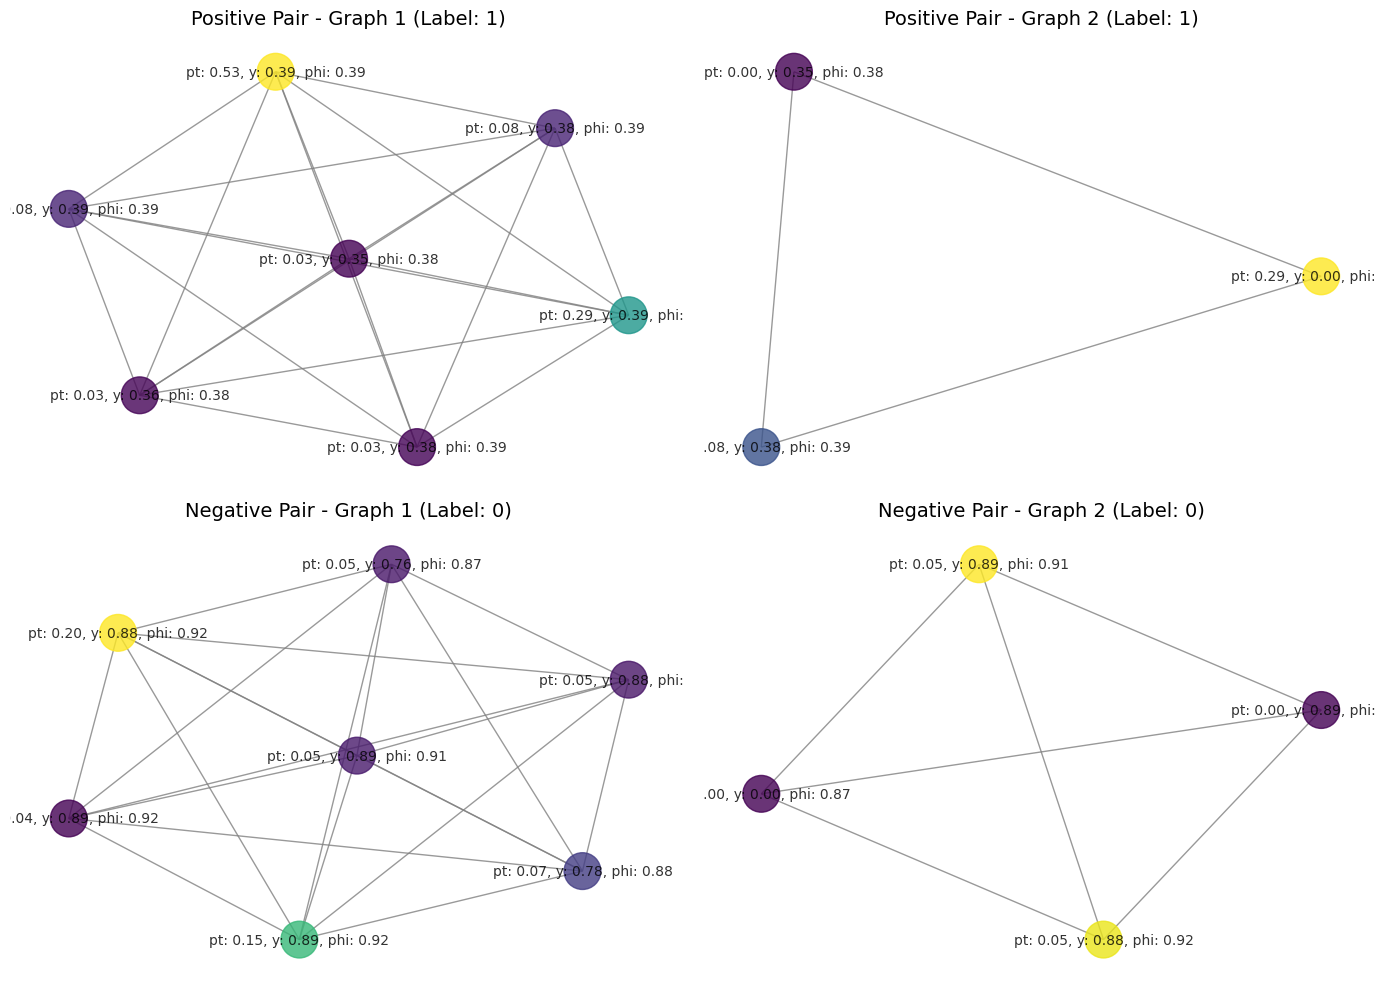

In [10]:
visualize_graph_pairs_01(pairs, labels)

In [11]:
class GraphPairDataset(Dataset):

    def __init__(self, pairs, labels):

        self.pairs = pairs  

        self.labels = labels 

        

    def __len__(self):

        return len(self.pairs)



    def __getitem__(self, idx):

        graph1, graph2 = self.pairs[idx]

        label = self.labels[idx]

        return graph1, graph2, label

In [12]:
def split_pairs(pairs, labels, train_ratio, val_ratio):

    train_pairs, temp_pairs, train_labels, temp_labels = train_test_split(

        pairs, labels, train_size=train_ratio, random_state=42, stratify=labels

    )

    val_pairs, test_pairs, val_labels, test_labels = train_test_split(

        temp_pairs, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels

    )

    

    return train_pairs, train_labels, val_pairs, val_labels, test_pairs, test_labels



train_ratio = 0.7

val_ratio = 0.15

test_ratio = 0.15



train_pairs, train_labels, val_pairs, val_labels, test_pairs, test_labels = split_pairs(

    pairs, labels, train_ratio, val_ratio

)

In [13]:
# Now, create datasets and dataloaders for each split

train_dataset = GraphPairDataset(train_pairs, train_labels)

val_dataset = GraphPairDataset(val_pairs, val_labels)

test_dataset = GraphPairDataset(test_pairs, test_labels)



batch_size = 1000



train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [14]:
# n_qubits = 6

data_size = 2**n_qubits



# Random normalized data for amplitude embedding

data = np.random.random(data_size)

data = data / np.linalg.norm(data)



# Random weights for parameterized RY rotations

weights = torch.randn(n_qubits, requires_grad=True)



# Run the quantum circuit

result = quantum_circuit_amplitude(data)

print(result)


[tensor(0.0679, dtype=torch.float64), tensor(0.0771, dtype=torch.float64), tensor(0.2148, dtype=torch.float64), tensor(0.0381, dtype=torch.float64), tensor(-0.1064, dtype=torch.float64), tensor(0.0084, dtype=torch.float64)]


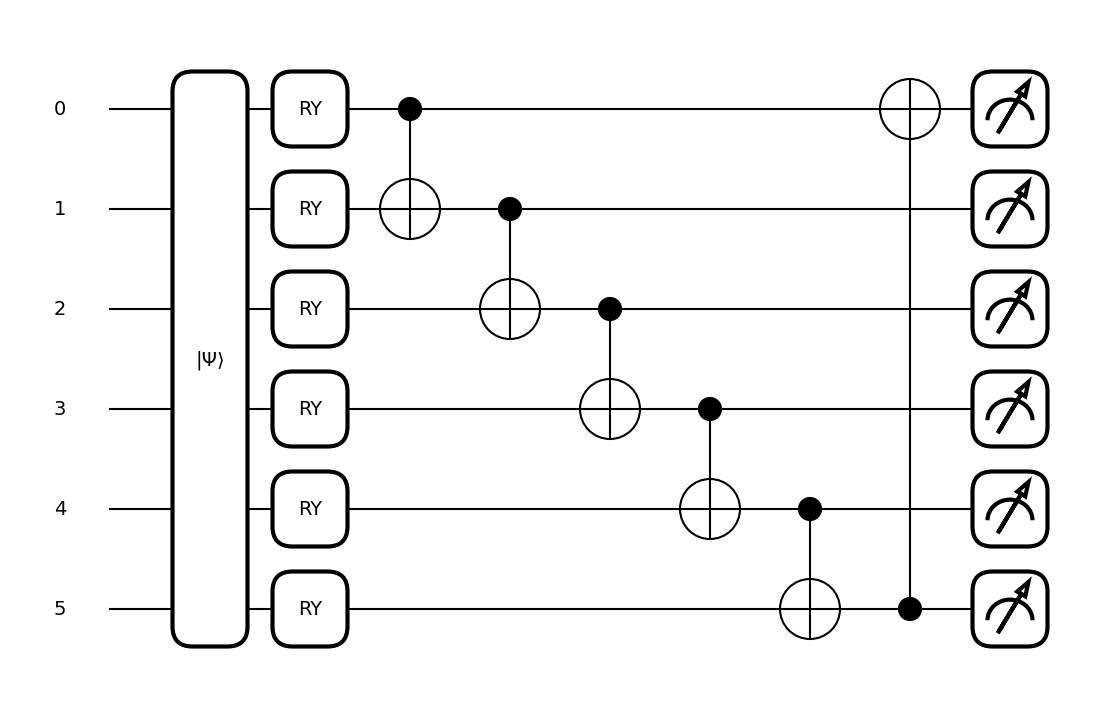

In [15]:
fig, ax = qml.draw_mpl(quantum_circuit_amplitude)(data)

# wandb.log({"QGNN Quantum Circuit": wandb.Image(fig)})

plt.show()

In [16]:
class QuantumLayer(torch.nn.Module):

    def __init__(self):

        super(QuantumLayer, self).__init__()



    def forward(self, x):

        q_out = []

        for i in range(x.shape[0]):  # Apply quantum circuit on each input in the batch

            qc_output = quantum_circuit_amplitude(x[i])

            # Convert the list output to a tensor

            q_out.append(torch.tensor(qc_output, dtype=torch.float32))

        return torch.stack(q_out)

In [17]:
model = HybridQuantumGNN(input_dims,hidden_dims,output_dims,ReLU(),QuantumLayer(), n_qubits)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

lossFn = ContrastiveLoss(margin=1.0)  # Use contrastive loss in pair mode

history = train_model(model, optimizer, lossFn=lossFn, epochs=50, lr=0.001, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

Epoch 1, Train Loss: 0.0105, Val Loss: 0.6148
Epoch 2, Train Loss: 0.0062, Val Loss: 0.0915
Epoch 3, Train Loss: 0.0051, Val Loss: 0.0297
Epoch 4, Train Loss: 0.0045, Val Loss: 0.0215
Epoch 5, Train Loss: 0.0042, Val Loss: 0.0194
Epoch 6, Train Loss: 0.0040, Val Loss: 0.0171
Epoch 7, Train Loss: 0.0039, Val Loss: 0.0154
Epoch 8, Train Loss: 0.0038, Val Loss: 0.0144
Epoch 9, Train Loss: 0.0037, Val Loss: 0.0141
Epoch 10, Train Loss: 0.0036, Val Loss: 0.0137
Epoch 11, Train Loss: 0.0035, Val Loss: 0.0130
Epoch 12, Train Loss: 0.0034, Val Loss: 0.0125
Epoch 13, Train Loss: 0.0034, Val Loss: 0.0123
Epoch 14, Train Loss: 0.0033, Val Loss: 0.0121
Epoch 15, Train Loss: 0.0032, Val Loss: 0.0115
Epoch 16, Train Loss: 0.0032, Val Loss: 0.0112
Epoch 17, Train Loss: 0.0032, Val Loss: 0.0110
Epoch 18, Train Loss: 0.0031, Val Loss: 0.0108
Epoch 19, Train Loss: 0.0031, Val Loss: 0.0106
Epoch 20, Train Loss: 0.0030, Val Loss: 0.0104
Epoch 21, Train Loss: 0.0030, Val Loss: 0.0100
Epoch 22, Train Loss: 

### LCT: Linear Classification Test

In [18]:
def run_model_lct(model, epoch, dataloader, lossFn, optimizer=None, train=True, return_embeddings=False):

    if train:

        model.train()

    else:

        model.eval()



    total_loss = 0

    correct = 0

    num_samples = 0

    all_embeddings = []

    all_labels = []



    for batch in dataloader:

        optimizer.zero_grad() if train else None



        # Extract the pairs and labels from the dataloader batch

        data1, data2, labels = batch[0], batch[1], batch[2]

        

        # Get the embeddings for both graphs

        emb1 = model(data1.x.float(), data1.edge_index, data1.batch)

        emb2 = model(data2.x.float(), data2.edge_index, data2.batch)

        

        if return_embeddings:

            # Save embeddings and labels for later use in classification

            all_embeddings.append(emb1.detach().cpu())

            all_labels.append(labels.detach().cpu())



        # Compute contrastive loss

        loss = lossFn(emb1, emb2)

        

        if train:

            loss.backward()

            optimizer.step()



        total_loss += loss.item() * data1.num_graphs

        num_samples += data1.num_graphs



        # Compute accuracy

        with torch.no_grad():

            cos_sim = torch.nn.functional.cosine_similarity(emb1, emb2)

            predictions = (cos_sim > 0.5).long()  # You can adjust the threshold

            correct += (predictions == labels).sum().item()



    avg_loss = total_loss / num_samples

    accuracy = correct / num_samples



    if return_embeddings:

        return torch.cat(all_embeddings, dim=0), torch.cat(all_labels, dim=0)

    return avg_loss, accuracy

In [19]:
# After training, use the run_model function to extract embeddings from the validation/test dataset

train_embeddings, train_labels = run_model_lct(model, epoch=0, dataloader=train_dataloader, lossFn=lossFn, return_embeddings=True, train=False)

test_embeddings, test_labels = run_model_lct(model, epoch=0, dataloader=test_dataloader, lossFn=lossFn, return_embeddings=True, train=False)



# Convert embeddings and labels to numpy arrays for scikit-learn

X_train = train_embeddings.cpu().numpy()

y_train = train_labels.cpu().numpy()

X_test = test_embeddings.cpu().numpy()

y_test = test_labels.cpu().numpy()

Linear Classifier Test Accuracy: 65.33%
QGNN AUC Score: 0.7083


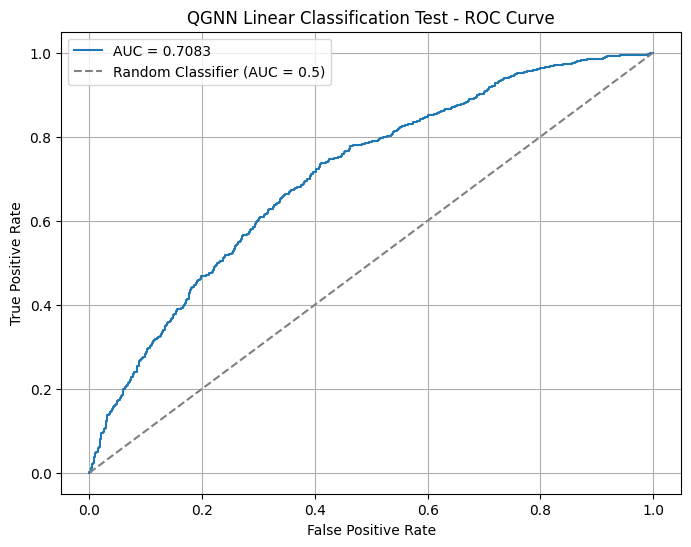

Confusion Matrix:
[[591 351]
 [299 634]]


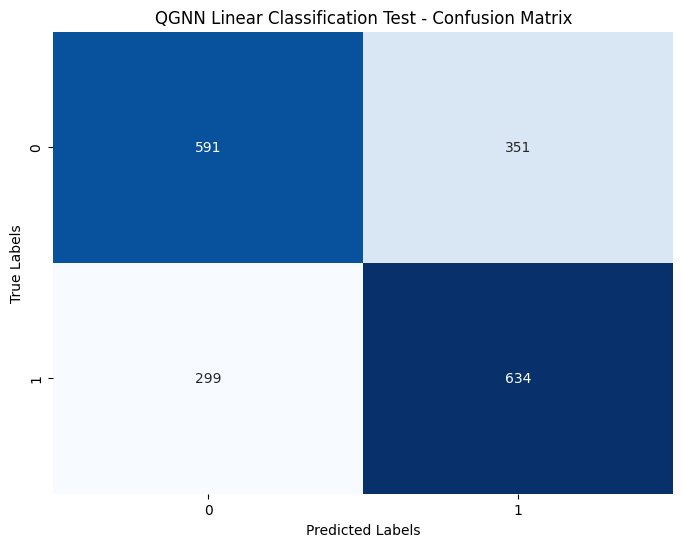

In [20]:
## Linear Classification Test

# Train a simple linear classifier (Logistic Regression)

classifier = LogisticRegression(max_iter=1000)

classifier.fit(X_train, y_train)



# Predict on test set

y_pred = classifier.predict(X_test)



# Compute accuracy of the linear classifier

accuracy = accuracy_score(y_test, y_pred)

print(f"Linear Classifier Test Accuracy: {accuracy * 100:.2f}%")

# wandb.log({"QGNN Linear Classifier Test Accuracy": f"{accuracy * 100:.2f}%"})



# Compute the AUC score and plot the ROC curve

if len(np.unique(y_test)) == 2:  # Binary classification

    y_prob = classifier.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

    auc_score = roc_auc_score(y_test, y_prob)

    print(f"QGNN AUC Score: {auc_score:.4f}")



    # Plot ROC curve

    fpr, tpr, _ = roc_curve(y_test, y_prob)

    plt.figure(figsize=(8, 6))

    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")

    

    # Add the diagonal line representing random guessing

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier (AUC = 0.5)")

    

    # Label the plot

    plt.xlabel("False Positive Rate")

    plt.ylabel("True Positive Rate")

    plt.title("QGNN Linear Classification Test - ROC Curve")

    plt.legend()

    plt.grid(True)

    

    # Save and log the plot to WandB

    plt.savefig("roc_curve.png")

    

    # Show the plot (optional)

    plt.show()



# Compute and display the confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")

print(conf_matrix)



# Plot the confusion matrix

plt.figure(figsize=(8, 6))

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.xlabel('Predicted Labels')

plt.ylabel('True Labels')

plt.title('QGNN Linear Classification Test - Confusion Matrix')



# Save and log the confusion matrix plot to WandB

plt.savefig("confusion_matrix.png")



plt.show()

In [21]:
import pandas as pd

from sklearn.metrics import roc_curve

import numpy as np





# Create a DataFrame with these values

roc_data = pd.DataFrame({

    'False Positive Rate': fpr,

    'True Positive Rate': tpr

})



y_data = pd.DataFrame({

    'y_test': y_test,

    'y_prob': y_prob

})



# Save to CSV

roc_data.to_csv('roc_curve_data.csv', index=False)

y_data.to_csv('y_data.csv', index=False)

In [22]:
roc_data

,False Positive Rate,True Positive Rate
0,0.000000,0.000000
1,0.000000,0.001072
2,0.000000,0.002144
3,0.002123,0.002144
4,0.002123,0.005359
...,...,...
839,0.993631,0.996785
840,0.993631,0.998928
841,0.994692,0.998928
842,0.994692,1.000000


In [23]:
# Save to CSV

roc_data.to_csv('/kaggle/working/roc_curve_data.csv', index=False)

y_data.to_csv('/kaggle/working/y_data.csv', index=False)